In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st

spark = SparkSession.builder.master('local').getOrCreate()

schema = st.StructType([
    st.StructField("date", st.DateType(), True),
    st.StructField("open", st.FloatType(), True),
    st.StructField("high", st.FloatType(), True),
    st.StructField("low", st.FloatType(), True),
    st.StructField("close", st.FloatType(), True),
    st.StructField("volume", st.FloatType(), True),
    st.StructField("currency", st.StringType(), True)
])

cdf = spark.read.csv("data/coffee.csv", header=True, 
schema=schema)

23/02/10 14:49:31 WARN Utils: Your hostname, alex-XPS-15-7590 resolves to a loopback address: 127.0.1.1; using 192.168.0.33 instead (on interface wlp59s0)
23/02/10 14:49:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/10 14:49:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
cdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- currency: string (nullable = true)



In [3]:
# lower case columns 
cdf = cdf.toDF(*[c.lower() for c in cdf.columns])

# Add a column to the DataFrame where the values are the difference between 'Open' and 'Close'
# Add a column to the DataFrame where the values are the difference between 'High' and 'Low'
# Add a column to the DataFrame where the values are 'True' if the volume for that day was 100 or above, and otherwise 'False'.

cdf = cdf \
  .withColumn("oc_diff", sf.round(cdf.open - cdf.close, 4)) \
  .withColumn("hl_diff", sf.round(cdf.high - cdf.low, 4)) \
  .withColumn("over_100", cdf.volume >= 100)

# Add another column that contains the absolute values of the numbers in oc_diff
# Compute a column called net_sales which is the average of opening, high, low, and closing cost times the volume

abs_map = sf.udf(lambda x: round(abs(x), 4), st.FloatType())

cdf = cdf \
  .withColumn("abs_oc_diff", abs_map(cdf.oc_diff)) \
  .withColumn("net_sales", sf.round((cdf.open + cdf.close + cdf.high + cdf.low)/4, 4).cast(st.FloatType()))


In [4]:
cdf.printSchema()

root
 |-- date: date (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)
 |-- currency: string (nullable = true)
 |-- oc_diff: float (nullable = true)
 |-- hl_diff: float (nullable = true)
 |-- over_100: boolean (nullable = true)
 |-- abs_oc_diff: float (nullable = true)
 |-- net_sales: float (nullable = true)



In [5]:
# Find the average of the values in the column that has the absolute values of the difference between 'Open' and 'Close'.
# Find the average 'Open' value.
# Get the highest 'High' value.

cdf.createOrReplaceTempView("coffee")
result = spark.sql("""
select ROUND(AVG(open), 4) as avg_open,
       ROUND(AVG(abs_oc_diff), 4) as avg_abs_oc_diff,
       MAX(high) as max_high 
from coffee
""")
result.show()

# Get the count of values where the 'Volume' was less than 100
cdf.filter(cdf.over_100 == False).count()

+--------+---------------+--------+
|avg_open|avg_abs_oc_diff|max_high|
+--------+---------------+--------+
|126.0497|         1.7606|  306.25|
+--------+---------------+--------+



1638

In [6]:
# Write to parquet 
cdf.write.parquet("data/coffee.parquet", mode="overwrite")

In [7]:
## Bonus -- Use Matplotlib to create a visualization (i.e. a chart) using the coffee data.
import matplotlib.pyplot as plt 

schema = st.StructType([
    st.StructField("date", st.DateType(), True),
    st.StructField("open", st.FloatType(), True),
    st.StructField("high", st.FloatType(), True),
    st.StructField("low", st.FloatType(), True),
    st.StructField("close", st.FloatType(), True),
    st.StructField("volume", st.FloatType(), True),
    st.StructField("currency", st.StringType(), True),
    st.StructField("oc_diff", st.FloatType(), True),
    st.StructField("hl_diff", st.FloatType(), True),
    st.StructField("over_100", st.BooleanType(), True),
    st.StructField("abs_oc_diff", st.FloatType(), True),
    st.StructField("net_sales", st.FloatType(), True)
])

cdf = spark.read.schema(schema).parquet("data/coffee.parquet/", header=True)

Text(0.5, 1.0, 'Daily Net Coffee Sales (USD)')

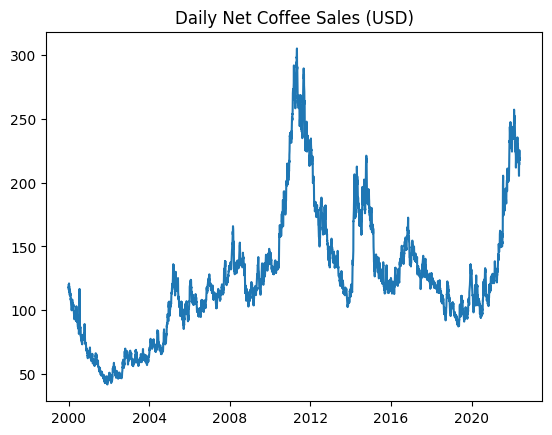

In [13]:
## Visualization: Line chart of daily price of coffee 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


pdf = cdf.toPandas()

plt.plot('date','net_sales', data=pdf)
plt.title("Daily Net Coffee Sales (USD)")


In [ ]:
## Upload parquet to bigquery 